In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 2.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 17.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=32c498bef5e10a9595cdfb33536fe587a4c12b0b0953d1f5185876a3e65f7ecc
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


# Imports

In [18]:
import pandas as pd
import numpy as np
import gc
from tqdm import tqdm
import gzip
import json

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, functions as F 
from pyspark import StorageLevel
from pyspark.sql.types import *
from pyspark.sql import Window

from pyspark.ml.evaluation import RegressionEvaluator, RankingEvaluator
from pyspark.ml.recommendation import ALS

from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Session

In [5]:
APP_NAME = 'bd_rs'

# spark = SparkSession.builder\
#     .appName(APP_NAME)\
#     .master("local[3]")\
#     .config('spark.ui.port', "4040")\
#     .getOrCreate()

spark = SparkSession.builder\
    .appName(APP_NAME)\
    .master("local[3]")\
    .config('spark.ui.port', "4040")\
    .config("spark.driver.memory", "14g")\
    .config("es.index.auto.create", "true")\
    .config("spark.executor.memory", "14g")\
    .getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", 20)  # it isn't a cluster, so 20 is enough

In [6]:
spark

# Reading

In [ ]:
!ls -la 

In [7]:
path = './Books_5.json.gz'

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

In [8]:
def getMetaData(path, total_n=1e6):
    data = []
    data_schema =  [
                    StructField("asin", StringType(), True),
                    StructField("reviewerID", StringType(), True),
                    StructField("reviewerName", StringType(), True),
                    StructField("reviewTime", StringType(), True),
                    StructField("unixReviewTime", StringType(), True),
                    StructField("overall", DoubleType(), True),
                    StructField("verified", BooleanType(), True),
                    StructField("reviewText", StringType(), True),
                    StructField("summary", StringType(), True),
                    StructField("format", StringType(), True),
                   ]
    final_schema = StructType(fields=data_schema)
    
    i = 0
    for d in tqdm(parse(path), total=total_n):
        
        if i > total_n:
            break
        
        review = {}
        review['asin'] = d['asin']
        review['reviewerID'] = d['reviewerID']
        
        try:
            review['reviewerName'] = d['reviewerName']
        except Exception as e:
#             print("Can't find reviewerName for asin={}".format(review['asin']))
            review['reviewerName'] = None
            
        review['reviewTime'] = d['reviewTime']
        review['unixReviewTime'] = d['unixReviewTime']
        review['overall'] = d['overall']
        review['verified'] = d['verified']
        
        try:
            review['reviewText'] = d['reviewText']
        except Exception as e:
#             print("Can't find reviewText for asin={}".format(review['asin']))
            review['reviewText'] = None
        try:   
            review['summary'] = d['summary']
        except Exception as e:
#             print("Can't find summary for asin={}".format(review['asin']))
            review['summary'] = None

        try:
            review['format'] = d['style']['Format:']
        except Exception as e:
#             print("Can't find format for asin={}".format(review['asin']))
            review['format'] = None
            
        data.append(review)
        i += 1

    return spark.createDataFrame(data, schema=final_schema)

In [9]:
%%time
TOTAL_N = 5e6
book_data = getMetaData(path=path, total_n=TOTAL_N)
# book_data = book_data.dropDuplicates(['asin'])

5000001it [02:12, 37736.99it/s]                               


CPU times: user 2min 55s, sys: 24.5 s, total: 3min 19s
Wall time: 3min 32s


In [10]:
N_PARTITION = 20

book_data = book_data.withColumn('reviewDate', F.from_unixtime('unixReviewTime', 'yyyy-MM-dd'))
book_data = book_data.repartition(N_PARTITION, 'asin').persist(StorageLevel.MEMORY_AND_DISK)

In [11]:
book_data.printSchema()

root
 |-- asin: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- unixReviewTime: string (nullable = true)
 |-- overall: double (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- format: string (nullable = true)
 |-- reviewDate: string (nullable = true)



In [12]:
max_date = book_data.agg({'reviewDate' : 'max'}).collect()[0]
max_date

23/01/15 16:49:21 WARN TaskSetManager: Stage 0 contains a task of very large size (1147771 KiB). The maximum recommended task size is 1000 KiB.


Row(max(reviewDate)='2018-05-03')

In [13]:
max_date_ = max_date[0]
max_date_

'2018-05-03'

In [14]:
# spark.catalog.clearCache()
gc.collect()

318

In [15]:
book_data.count()

5000001

In [16]:
gc.collect()

1131

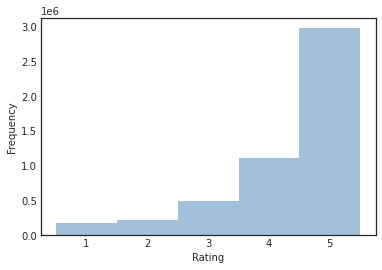

In [20]:
reviews = book_data.select('overall').collect()
review_list = [reviews[i][0] for i in range(len(reviews))]

plt.hist(review_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')
plt.savefig('my_image.png')
plt.show()

# RS

## Indexing

In [13]:
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['asin', 'reviewerID']]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(book_data).transform(book_data)
transformed.show(3)

23/01/15 14:29:01 WARN DAGScheduler: Broadcasting large task binary with size 46.7 MiB


+----------+--------------+-------------------+-----------+--------------+-------+--------+--------------------+--------------------+----------+----------+----------+----------------+
|      asin|    reviewerID|       reviewerName| reviewTime|unixReviewTime|overall|verified|          reviewText|             summary|    format|reviewDate|asin_index|reviewerID_index|
+----------+--------------+-------------------+-----------+--------------+-------+--------+--------------------+--------------------+----------+----------+----------+----------------+
|0000230022|  AYQGXWZP7S2G|Douglas N. Petersen|01 29, 2011|    1296259200|    5.0|   false|How soon we forge...|         Inspiring!!| Hardcover|2011-01-29|   46568.0|       1315808.0|
|0000230022|A2WE6C7MXY3W8E|       Ann Snelling|01 29, 2011|    1296259200|    5.0|    true|The story of John...|Simple Truths of ...| Hardcover|2011-01-29|   46568.0|        741058.0|
|0000230022|A38AAPXSJN4C5G|   Edward J. Barton|12 27, 2010|    1293408000|    5.

## Splitting data

In [14]:
transformed_ = transformed.select('reviewerID_index', 'asin_index', 'overall')

Getting for test reviews after (max_date - 1 year)

In [15]:
trainset = transformed_.filter(F.col('reviewDate') < F.add_months(F.to_date(F.lit(max_date_)), -12))
testset = transformed_.filter(F.col('reviewDate') >= F.add_months(F.to_date(F.lit(max_date_)), -12))

## Train

In [16]:
gc.collect()

355

In [17]:
%%time
als=ALS(maxIter=5,
        regParam=0.07,
        rank=15,
        userCol="reviewerID_index",
        itemCol="asin_index",
        ratingCol="overall",
        coldStartStrategy="drop",
        nonnegative=True)
model=als.fit(trainset)

23/01/15 14:29:13 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:29:20 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:29:47 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:30:10 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:30:26 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:30:48 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:31:01 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:31:15 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:31:33 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:32:19 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:32:49 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:33:25 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:33:44 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:34:14 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:34:32 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:35:02 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:35:20 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 14:35:49 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


CPU times: user 415 ms, sys: 78.2 ms, total: 494 ms
Wall time: 7min 2s


## Prediction

In [19]:
predictions_train = model.transform(trainset)
predictions_test = model.transform(testset).na.drop().persist(StorageLevel.MEMORY_AND_DISK)

## Metric

In [18]:
gc.collect()

306

## RMSE

Error-based

In [38]:
%%time
evaluator=RegressionEvaluator(metricName="rmse",labelCol="overall", predictionCol="prediction")

rmse_train=evaluator.evaluate(predictions_train)
rmse_test=evaluator.evaluate(predictions_test)
# 0.40, 1.49
print("RMSE TRAIN = "+str(rmse_train))
print("RMSE TEST = "+str(rmse_test))

23/01/15 15:53:34 WARN DAGScheduler: Broadcasting large task binary with size 46.7 MiB


23/01/15 15:53:38 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 15:53:43 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 15:54:25 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 15:54:36 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 15:54:54 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 15:55:14 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


RMSE TRAIN = 0.4529286785524439
RMSE TEST = 1.6726373109122816
CPU times: user 131 ms, sys: 24.4 ms, total: 155 ms
Wall time: 1min 46s


In [ ]:
predictions_test.select('asin_index', 'reviewerID_index', 'overall', 'prediction').show(10, 0)

## Ranking-based

In [ ]:
predictions_test = predictions_test.withColumn('prediction_new',
                                               F.when(predictions_test.prediction > 5.0, 5.0).otherwise(predictions_test.prediction))

In [33]:
w_overall = Window.orderBy(F.desc("overall"))
w_prediction = Window.orderBy(F.desc("prediction"))
w_prediction_new = Window.orderBy(F.desc("prediction_new"))

predictions_test = predictions_test.withColumn("overall_rank", F.dense_rank().over(w_overall))\
.withColumn("prediction_rank", F.dense_rank().over(w_prediction))\
.withColumn("prediction_new_rank", F.dense_rank().over(w_prediction_new))

In [35]:
ranked_test = predictions_test.groupby('reviewerID_index')\
.agg(F.collect_list(F.col('overall_rank').cast('double')).alias('overall_rank_items'),
    F.collect_list(F.col('prediction_rank').cast('double')).alias('prediction_rank_items'),
    F.collect_list(F.col('prediction_new_rank').cast('double')).alias('prediction_new_rank_items'))

In [36]:
%%time
rank_evaluator=RankingEvaluator(metricName="meanAveragePrecisionAtK",k=5, labelCol="overall_rank_items", predictionCol="prediction_new_rank_items")
map_k=rank_evaluator.evaluate(ranked_test)
print("Mean Average Precision at K=5 = "+ str(map_k))

23/01/15 15:33:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/15 15:33:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/15 15:33:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/15 15:33:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/15 15:34:01 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 15:34:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/15 15:34:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/15 15:34:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/15 15:34:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/15 15:34:30 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


Mean Average Precision at K=10 = 0.06256047278049465
CPU times: user 40.9 ms, sys: 9.77 ms, total: 50.6 ms
Wall time: 33.6 s


In [37]:
%%time
rank_evaluator=RankingEvaluator(metricName="ndcgAtK",k=5, labelCol="overall_rank_items", predictionCol="prediction_new_rank_items")
ndcg_K=rank_evaluator.evaluate(ranked_test)
print("NDCG at K=5 = "+ str(ndcg_K))

23/01/15 15:34:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/15 15:34:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/15 15:34:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/15 15:34:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/15 15:34:48 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


23/01/15 15:35:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/15 15:35:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/15 15:35:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/15 15:35:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/15 15:35:18 WARN DAGScheduler: Broadcasting large task binary with size 46.8 MiB


NDCG at K=10 = 0.06258037479786793
CPU times: user 42.2 ms, sys: 9.19 ms, total: 51.4 ms
Wall time: 34.5 s


# Recomendstions

In [ ]:
%%time
recs = model.recommendForAllUsers(5).persist(StorageLevel.MEMORY_AND_DISK)
book_data.unpersist()

In [ ]:
%%time
predictions_test_ = predictions_test.select('reviewerID_index').distinct()
recs_test = predictions_test_.join(recs, on='reviewerID_index', how='left')

In [ ]:
recs_test.show(5, 0)